# Ch03 TrendFollowing(A233740)

In [140]:
import numpy as np 
import pandas as pd 
import pyfolio as pf

import matplotlib as mpl
import matplotlib.pyplot as plt

from datetime import datetime
from adv_finance import bars, labeling, utils

from matplotlib.patches import Rectangle
import  matplotlib.dates as mdates


/opt/conda/envs/python372/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [2]:
%load_ext autoreload 
%autoreload 2


plt.style.use('seaborn-talk')
plt.style.use('bmh')
pd.set_option('display.max_rows', 100)


In [151]:
df.head()

,open,high,low,close,vol,fast_mavg,slow_mavg,side
timestamp,,,,,,,,
2018-01-02 10:06:59.419,20095,20105,19950,19950,183928,20048.333333,20077.500000,1.0
2018-01-02 10:09:19.131,19950,19950,19805,19825,230527,19956.666667,20027.000000,-1.0
2018-01-02 10:12:36.511,19825,20010,19815,20010,288935,19928.333333,20024.166667,-1.0
2018-01-02 10:16:11.580,20010,20080,19965,19970,230531,19935.000000,20016.428571,-1.0
2018-01-02 10:20:39.597,19970,20070,19945,20010,281567,19996.666667,20015.625000,-1.0


In [152]:
df.loc['2018-01-03'].shape

(243, 8)

## Fit a Primary Model: Trend Following

In [52]:
# TRADE_A233740 = pd.read_parquet('/nfs/data/interim_2018/TRADE_A233740.parq')

In [3]:
TRADE_A233740_DRB = pd.read_parquet('/nfs/data/interim_2018/TRADE_A233740_DRB.parq')
df = TRADE_A233740_DRB[['open', 'high', 'low', 'close', 'vol']].drop_duplicates()
df = df.loc[~df.index.duplicated(keep='first')]
close = df

In [80]:
data = df

# compute moving average 
fast_window = 3
slow_window = 9

data['fast_mavg'] = data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
data['slow_mavg'] = data['close'].rolling(window=slow_window, min_periods=fast_window, center=False).mean()
data.head()

,open,high,low,close,vol,fast_mavg,slow_mavg,side
timestamp,,,,,,,,
2018-01-02 10:02:09.479,20080,20165,20075,20165,154758,NaN,NaN,1.0
2018-01-02 10:03:16.252,20165,20225,20085,20100,265815,NaN,NaN,1.0
2018-01-02 10:05:41.351,20100,20130,20055,20095,294097,20120.000000,20120.0,1.0
2018-01-02 10:06:59.419,20095,20105,19950,19950,183928,20048.333333,20077.5,1.0
2018-01-02 10:09:19.131,19950,19950,19805,19825,230527,19956.666667,20027.0,1.0


In [81]:
# Compute sides 
data['side'] = np.nan 

long_signals = data['fast_mavg'] >= data['slow_mavg']
short_signals = data['fast_mavg'] < data['slow_mavg']
data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

# Remove look ahead bias by lagging the signal 
data['side'] = data['side'].shift(1)


In [82]:
raw_data = data.copy()

data.dropna(axis=0, how='any', inplace=True)

## FIlter Events: CUSUM Filter

In [83]:
daily_vol = utils.get_daily_vol(data[['close']])
threshold = daily_vol['close'].mean() * 0.5
cusum_events = labeling.cusum_filter(data[['close']], threshold)
vertical_barriers = labeling.add_vertical_barrier(t_events=cusum_events, close=df[['close']], num_days=1)

In [84]:
pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = labeling.get_events(close=df['close'],
                                            t_events=cusum_events,
                                            pt_sl=pt_sl,
                                            target=daily_vol['close'],
                                            min_ret=min_ret,
                                            num_threads=1,
                                            vertical_barrier_times=vertical_barriers,
                                            side_prediction=data['side'])


/nfs/code/adv_finance/adv_finance/labeling/labeling.py:111: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]


In [85]:
# labels = labeling.get_bins(triple_barrier_events, df[['close']])


In [86]:
def barrier_touched(out_df): 
    store = []
    for i in np.arange(len(out_df)):
        date_time = out_df.index[i]
        ret = out_df.loc[date_time, 'ret']
        target = out_df.loc[date_time, 'trgt']

        if ret > 0.0 and ret > target:
            # Top barrier reached
            store.append(1)
        elif ret < 0.0 and ret < -target:
            # Bottom barrier reached
            store.append(-1)
        else:
            # Vertical barrier reached
            store.append(0)

    out_df['bin'] = store
    return out_df


def get_bins(triple_barrier_events, close): 
    
    # 1) Align prices with their respective events
    events_ = triple_barrier_events.dropna(subset=['t1'])
    prices = events_.index.union(events_['t1'].values)
    prices = prices.drop_duplicates()
    # prices = close.reindex(prices, method='bfill')
    prices = close.reindex(prices).bfill()

    # 2) Create out DataFrame
    out_df = pd.DataFrame(index=events_.index)

    # Need to take the log returns, else your results will be skewed for short positions
    out_df['ret'] = np.log(prices.loc[events_['t1'].values].values) - np.log(prices.loc[events_.index])
    out_df['trgt'] = events_['trgt']

    # Meta labeling: Events that were correct will have pos returns
    if 'side' in events_:
        out_df['ret'] = out_df['ret'] * events_['side'] # meta-labeling

    # Added code: label 0 when vertical barrier reached
    out_df = barrier_touched(out_df)

    # Meta labeling: label incorrect events with a 0
    if 'side' in events_:
        out_df.loc[out_df['ret'] <= 0, 'bin'] = 0

    # Transform the log returns back to normal returns.
    out_df['ret'] = np.exp(out_df['ret']) - 1

    # Add the side to the output. This is useful for when a meta label model must be fit
    tb_cols = triple_barrier_events.columns
    if 'side' in tb_cols:
        out_df['side'] = triple_barrier_events['side']

    return out_df


In [87]:
labels = get_bins(triple_barrier_events, df[['close']])

## Results of Primary Model: 

In [88]:
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [89]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print('Confusion Matrix')
print(confusion_matrix(actual, pred))

print('')
print('Accuracy')
print(accuracy_score(actual, pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1598
           1       0.47      1.00      0.64      1442

   micro avg       0.47      0.47      0.47      3040
   macro avg       0.24      0.50      0.32      3040
weighted avg       0.23      0.47      0.31      3040

Confusion Matrix
[[   0 1598]
 [   0 1442]]

Accuracy
0.4743421052631579


/opt/conda/envs/python372/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Fit a Meta Model 

In [120]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()
raw_data['volatility_9'] = raw_data['log_ret'].rolling(window=9, min_periods=9, center=False).std()
raw_data['volatility_3'] = raw_data['log_ret'].rolling(window=3, min_periods=3, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 15

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

In [121]:
# Re compute sides
raw_data['side'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [122]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

### Now get the data at the specified events

In [123]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']

### Balance classes

In [124]:
# Split data into training, validation and test sets
X_training_validation = X['2018-01-02':'2018-12-31']
y_training_validation = y['2018-01-02':'2018-12-31']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.15, shuffle=False)

In [125]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

0    1349
1    1235
Name: bin, dtype: int64

In [126]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

1    1349
0    1349
Name: bin, dtype: int64

In [127]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

## Fit a model

In [128]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [129]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.54562885 0.5944606  0.59634929 0.60268709 0.60462815 0.60509607
 0.60480476 0.55764206 0.60979632 0.61685814 0.61707517 0.61808499
 0.61860324 0.6201184  0.56115198 0.61773434 0.631501   0.63444023
 0.63615156 0.63779637 0.63954832 0.56811311 0.63491704 0.65357201
 0.66046403 0.66406888 0.66614241 0.66725687 0.57920132 0.66891001
 0.7070298  0.72087681 0.72529339 0.72929727 0.73015807]
512 7 42


In [130]:
# Refit a new model with best params, so we can see feature importance
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)

rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=512, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## Training Metrics

              precision    recall  f1-score   support

           0       0.86      0.76      0.81      1349
           1       0.78      0.88      0.83      1349

   micro avg       0.82      0.82      0.82      2698
   macro avg       0.82      0.82      0.82      2698
weighted avg       0.82      0.82      0.82      2698

Confusion Matrix
[[1022  327]
 [ 165 1184]]

Accuracy
0.8176426982950333


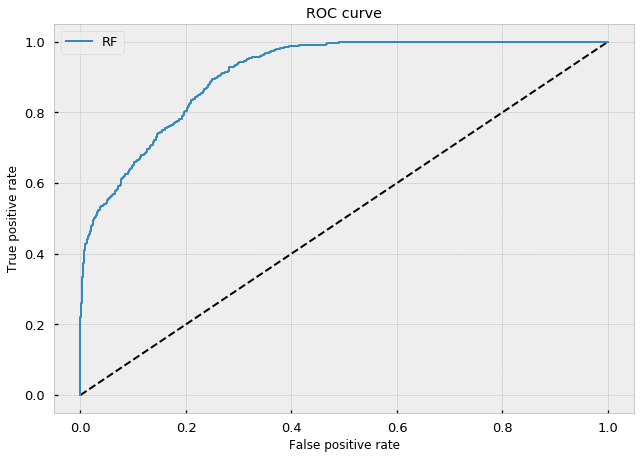

In [131]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Validation Metrics

              precision    recall  f1-score   support

           0       0.55      0.58      0.56       249
           1       0.46      0.43      0.45       207

   micro avg       0.51      0.51      0.51       456
   macro avg       0.51      0.51      0.51       456
weighted avg       0.51      0.51      0.51       456

Confusion Matrix
[[144 105]
 [117  90]]

Accuracy
0.5131578947368421


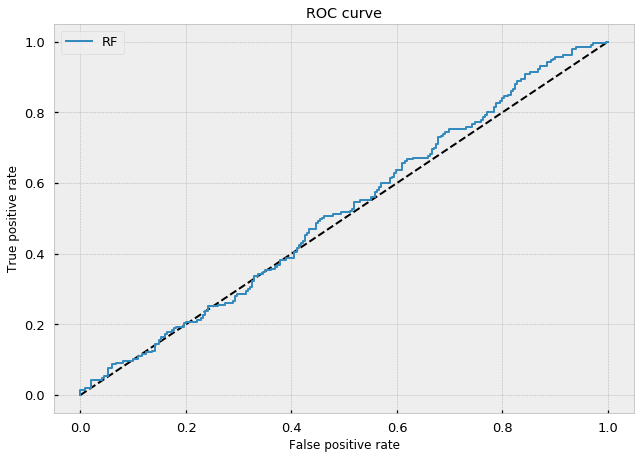

In [132]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_pred = rf.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [133]:
print(X_validate.index.min())
print(X_validate.index.max())

2018-11-08 13:32:25.791000
2018-12-27 14:58:54.318000


In [134]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

start = primary_forecast.index.get_loc('2018-11-08 13:32:25.791000')
end = primary_forecast.index.get_loc('2018-12-27 14:58:54.318000') + 1

subset_prim = primary_forecast[start:end]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       249
           1       0.45      1.00      0.62       207

   micro avg       0.45      0.45      0.45       456
   macro avg       0.23      0.50      0.31       456
weighted avg       0.21      0.45      0.28       456

Confusion Matrix
[[  0 249]
 [  0 207]]

Accuracy
0.45394736842105265


/opt/conda/envs/python372/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


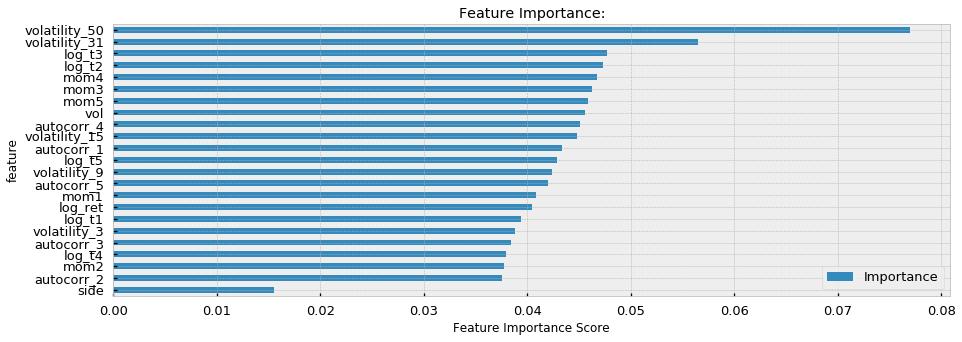

In [135]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

# Performance Tear Sheets(In-sample)

### Without Meta Labeling

In [136]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [137]:
valid_dates = X_validate.index
base_rets = labels.loc[valid_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)

In [141]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

In [142]:
# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

pf.show_perf_stats(primary_model_rets)

Start date,2018-11-09
End date,2018-12-27
Total months,1
,Backtest
Annual return,1899.6%
Cumulative returns,51.6%
Annual volatility,103.7%
Sharpe ratio,3.40
Calmar ratio,123.49
Stability,0.77
Max drawdown,-15.4%


### With Meta Labeling 

In [143]:
meta_returns = labels.loc[valid_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

In [144]:
# Save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_meta_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model'] = perf_stats_all

pf.show_perf_stats(daily_meta_rets)

Start date,2018-11-09
End date,2018-12-27
Total months,1
,Backtest
Annual return,-44.7%
Cumulative returns,-7.9%
Annual volatility,176.9%
Sharpe ratio,0.50
Calmar ratio,-1.01
Stability,0.02
Max drawdown,-44.4%


# Perform out-of-sample test 

## Meta Model Metrics

In [145]:
# Extarct data for out-of-sample (OOS)
X_oos = X['2018-01-02':]
y_oos = y['2018-01-02':]

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1598
           1       0.69      0.68      0.68      1442

   micro avg       0.70      0.70      0.70      3040
   macro avg       0.70      0.70      0.70      3040
weighted avg       0.70      0.70      0.70      3040

Confusion Matrix
[[1166  432]
 [ 466  976]]

Accuracy
0.7046052631578947


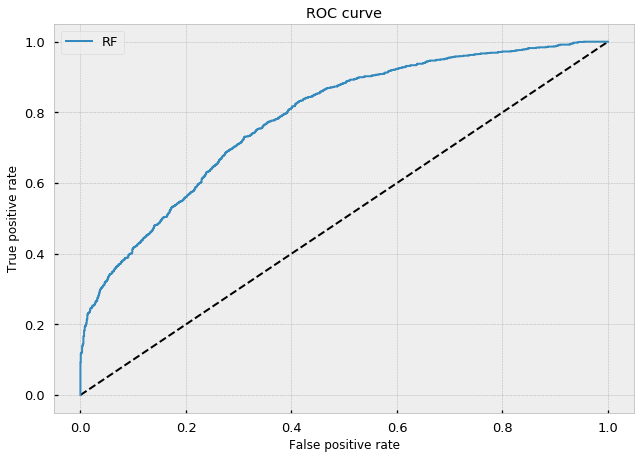

In [146]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_oos)[:, 1]
y_pred = rf.predict(X_oos)
fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
print(classification_report(y_oos, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_oos, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_oos, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [147]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

subset_prim = primary_forecast['2018-01-02':]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1598
           1       0.47      1.00      0.64      1442

   micro avg       0.47      0.47      0.47      3040
   macro avg       0.24      0.50      0.32      3040
weighted avg       0.23      0.47      0.31      3040

Confusion Matrix
[[   0 1598]
 [   0 1442]]

Accuracy
0.4743421052631579


/opt/conda/envs/python372/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Primary Model(Test Data)

In [148]:
test_dates = X_oos.index

# Downsample to daily
prim_rets_test = labels.loc[test_dates, 'ret']
daily_rets_prim = get_daily_returns(prim_rets_test)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=daily_rets_prim, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Primary Model OOS'] = perf_stats_all

# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(daily_rets_prim)

Start date,2018-01-04
End date,2018-12-27
Total months,12
,Backtest
Annual return,613.5%
Cumulative returns,636.1%
Annual volatility,216.5%
Sharpe ratio,1.58
Calmar ratio,12.46
Stability,0.68
Max drawdown,-49.3%


## Meta Model(Test Data)

Start date,2018-01-04
End date,2018-12-27
Total months,12
,Backtest
Annual return,12932067.9%
Cumulative returns,15588566.8%
Annual volatility,243.0%
Sharpe ratio,5.84
Calmar ratio,291359.43
Stability,0.96
Max drawdown,-44.4%


/opt/conda/envs/python372/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,44.39,2018-11-13,2018-11-16,NaT,NaN
1,21.37,2018-01-10,2018-01-11,2018-01-12,3
2,17.25,2018-08-28,2018-09-04,2018-10-04,28
3,16.03,2018-03-27,2018-03-30,2018-04-05,8
4,14.84,2018-07-30,2018-08-03,2018-08-08,8


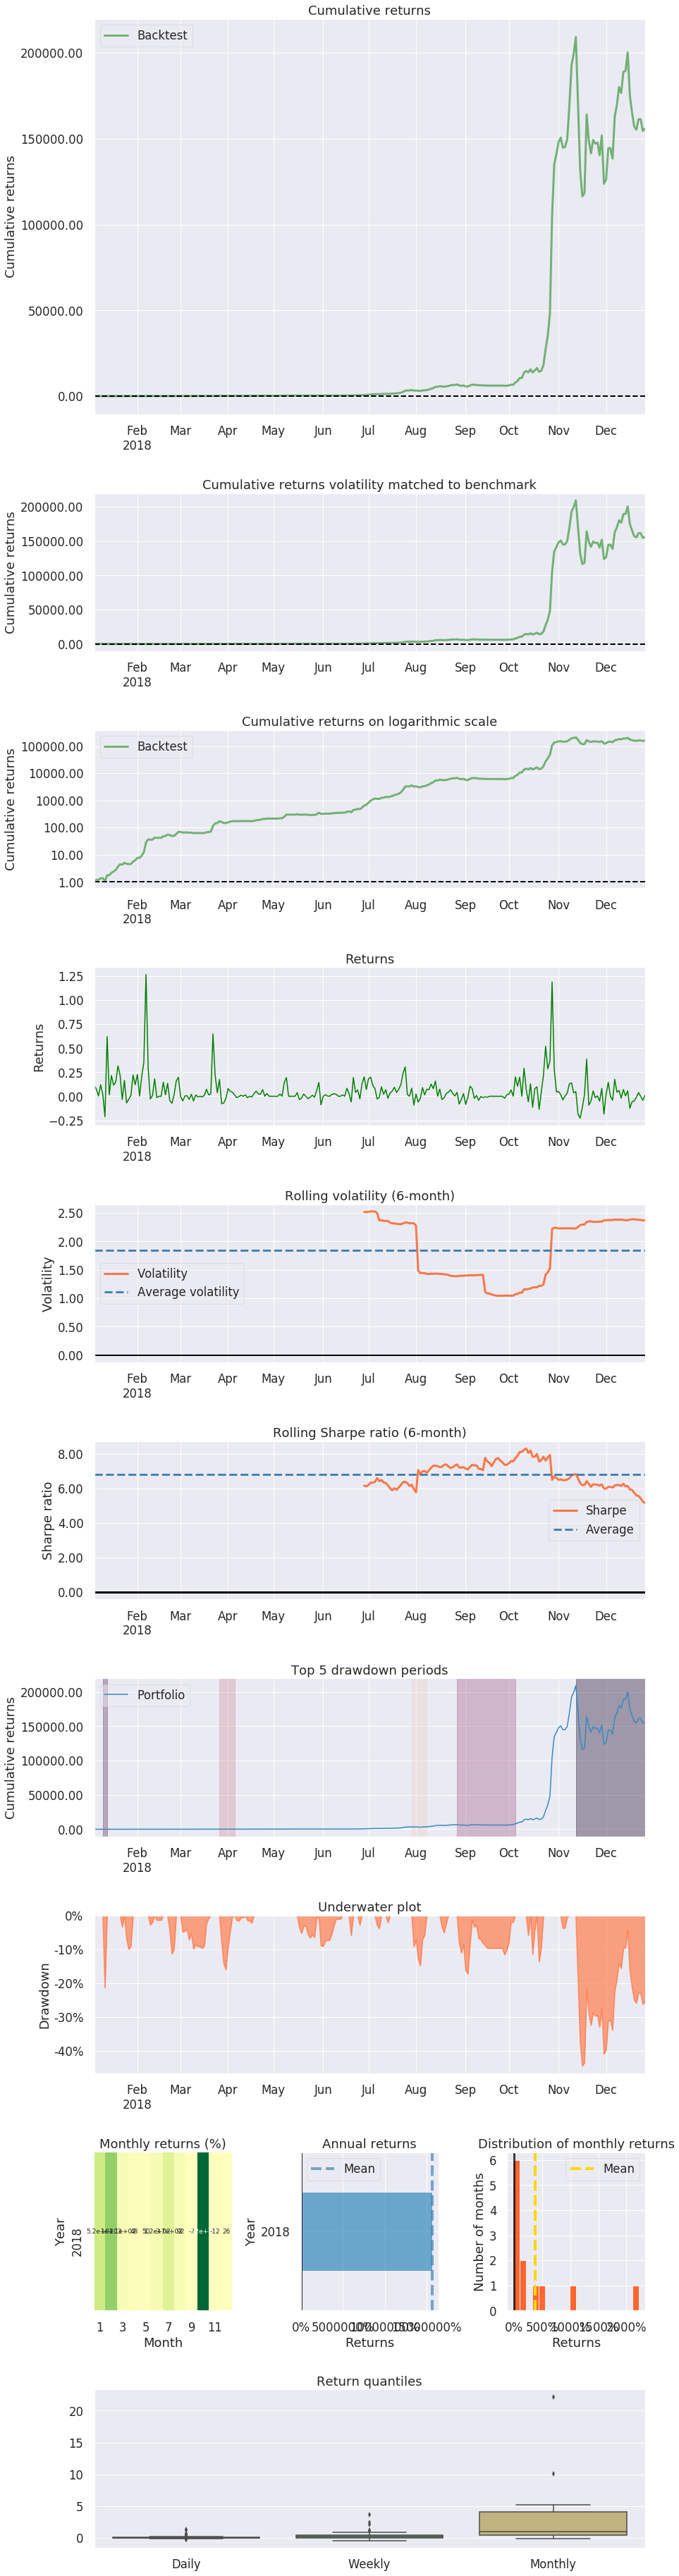

In [149]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_rets_meta, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model OOS'] = perf_stats_all

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)